# Fit regression models of seal abundance and presence
This notebook uses the information on the estimated number of seals per 5 x 5 KM grid cell to build regression models that aim to explain some of the factors that explain the observed distribution and abundance of Weddell seals around Antarctica.

Run this file every time you run the notebook "Attribute geospatial data with seal abundance data", as it means you have new geospatial covariates to analyze.

### Loading the required libraries and other dependencies

In [77]:
## Clear memory
rm(list=ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1299498,69.5,2637877,140.9,2637877,140.9
Vcells,1657833,12.7,22658849,172.9,41186610,314.3


In [159]:
libs<-c("ggplot2","plyr","dplyr","sp","rgeos","raster","rgdal")
lapply(libs, require, character.only = TRUE)
pathToLocalGit<-"/home/ubuntu/Workspace/ContinentalWESEestimates/"

## Load the source utility functions file
source(file=paste0(pathToLocalGit,"scripts/fitRegressionModels_functions.R"))

## load the WESE grid data
load(file=paste0(pathToLocalGit,"data/continentalWESE.RData"))
head(wesedf)
names(wesedf)

dataproj<-"+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

,gridCellId,meanslope,meanbathy,slope,bathy,shoredist,glacierdist,nearLineId,near_x,near_y,⋯,adpecol,empedist,empecol,cont300dist,cont800dist,coords.x1,coords.x2,mdlCol,mdlIsl,hasMaps
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,68791,2.621992,-2846.908,2.5563672,-2864.911,206728.3,247849.6,2351,-2273383,2327082,⋯,Ferrier Peninsula,1013124,Snow Hill Island,142791.6,588996.1,-2191000,2511000,0,0,0
2,68792,4.591249,-2587.330,4.4836812,-2612.724,208790.2,250334.0,2351,-2273383,2327082,⋯,Ferrier Peninsula,1014024,Snow Hill Island,142791.6,588996.1,-2186000,2511000,0,0,0
3,68819,1.411659,-3014.080,1.5170590,-3024.577,200154.1,241050.2,2351,-2273383,2327082,⋯,Ferrier Peninsula,1007323,Snow Hill Island,138016.9,584654.8,-2196000,2506000,0,0,0
4,68820,1.413779,-2920.630,0.7565953,-2930.036,202161.9,243501.3,2351,-2273383,2327082,⋯,Ferrier Peninsula,1008204,Snow Hill Island,138016.9,584654.8,-2191000,2506000,0,0,0
5,68821,4.561732,-2686.220,4.5623317,-2716.875,204263.8,246029.6,2351,-2273383,2327082,⋯,Ferrier Peninsula,1009109,Snow Hill Island,138016.9,584654.8,-2186000,2506000,0,0,0
6,68822,4.902608,-2264.930,5.1146288,-2277.257,206460.4,248632.8,2351,-2273383,2327082,⋯,Ferrier Peninsula,1010037,Snow Hill Island,138016.9,584654.8,-2181000,2506000,0,0,0


[1] "gridCellId"  "meanslope"   "meanbathy"   "slope"       "bathy"      
 [6] "shoredist"   "glacierdist" "nearLineId"  "near_x"      "near_y"     
[11] "distToShore" "adpedist"    "adpecol"     "empedist"    "empecol"    
[16] "cont300dist" "cont800dist" "coords.x1"   "coords.x2"   "mdlCol"     
[21] "mdlIsl"      "hasMaps"

## Regresion analysis preliminaries

The above tble (wesedf) is ready for fitting regression models, but first we will need the following:
1. Be able to extend the attribution of the table with geospatial hypotheses (e.g., David's WESE zones vs. Michelle's WESE zones)
2. Generate N samples of "no-seal" locations of identical size as the number of grid cells with WESE presence
3. Be able to compute a linear model with the set of N bootstrap samples, and have it summarized for us
  
### On the above needs
__Regarding #1__ it is done with the functions "readShapeFile" and "attributeWithShape". The first function reads the shape file into a spatial object and the second one uses information on the spatial object (e.g., David's WESE zones) into the data.  
Here's an example to load a point shapefile, from an example copied into the repository's data folder:

OGR data source with driver: ESRI Shapefile 
Source: "/home/ubuntu/Workspace/ContinentalWESEestimates/data/AntarcticRegions", layer: "Antarctic_Regions_WESE"
with 8 features
It has 4 fields


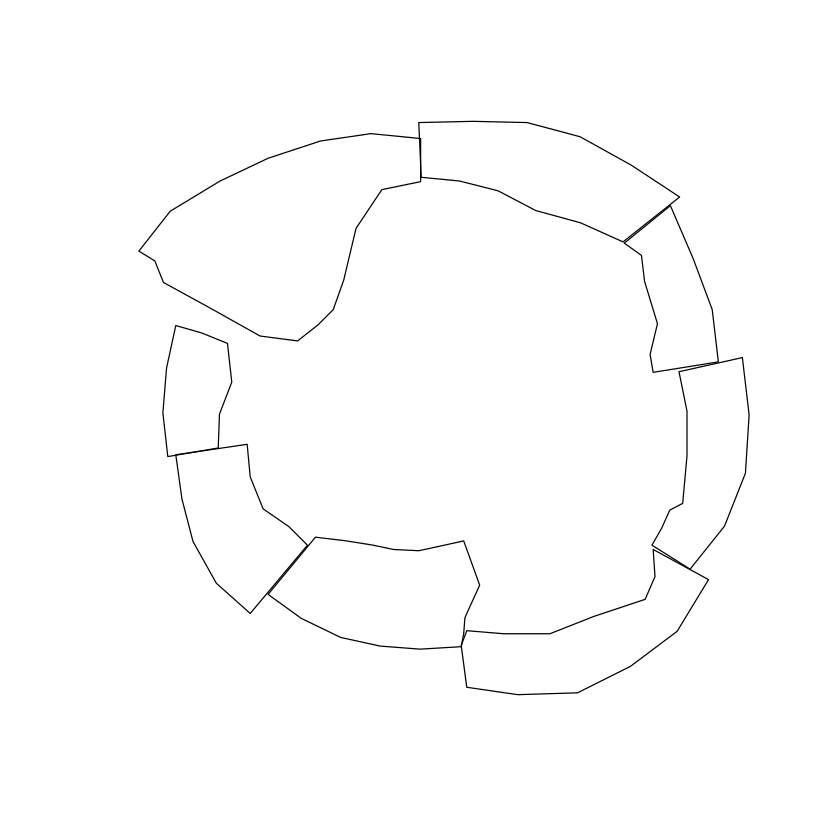

In [105]:
arWESE<-readShapeFile(pathToGit=pathToLocalGit,folderName="AntarcticRegions",shapeName="Antarctic_Regions_WESE")
#folderName is the folder name in the workspace, and shapeName is the name of the .shp file
plot(arWESE)

We could (but we don't because this is a point shapefile, not a polygon shapefile) use the spatial object "icebergs" ploted above to attribute wesedf with some information in it. We can see the contents of "icebergs" with a head:

In [106]:
head(arWESE)

,Id,RegionName,region,desc_
,<int>,<fct>,<int>,<fct>
0,0,Ross Sea,1,"Bathymetry, EMPE, ADPE, ice extent"
1,0,Amundsen Sea,2,"ice extent, ice duration, ADPE"
2,0,Bellingshausen Sea,3,"ADPE, ice extent, ice duration"
3,0,Weddell Sea,4,"Bathymetry, EMPE, ADPE, ice extent, ice duration"
4,0,Queen Maud Land,5,"Bathymetry, EMPE, ADPE"
5,0,Southern Indian Ocean,6,"Bathymetry, ADPE, ice duration"


So, we could attribute the wesedf table with the parameter "place_name", like so:

In [129]:
wesedf2<-attributeWithShape(shpobj=arWESE,attribName="RegionName",data=wesedf,datKey="gridCellId",
                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)

The example shapefileAntarcticRegions did not go far north enough to cover the entire fast ice region, so about 1/5 of all grid cells did not get attributed with a region name. Unfortunately, some of those grid cells missing region attribution had seals.

In [142]:
head(wesedf2)    #see the data
aa<-aggregate(gridCellId~RegionName,wesedf2,NROW)
    names(aa)<-c("RegionName","Num.Cells"); print(aa)    #count number of grid cells per region
sum(is.na(wesedf2$RegionName))    #How many grid cells without region attribution
sum(is.na(wesedf2$RegionName) & wesedf2$mdlCol>0)   #How many grid cells without a region yet with WESE?

,gridCellId,meanslope,meanbathy,slope,bathy,shoredist,glacierdist,nearLineId,near_x,near_y,⋯,empedist,empecol,cont300dist,cont800dist,coords.x1,coords.x2,mdlCol,mdlIsl,hasMaps,RegionName
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,68791,2.621992,-2846.908,2.5563672,-2864.911,206728.3,247849.6,2351,-2273383,2327082,⋯,1013124,Snow Hill Island,142791.6,588996.1,-2191000,2511000,0,0,0,NA
2,68792,4.591249,-2587.330,4.4836812,-2612.724,208790.2,250334.0,2351,-2273383,2327082,⋯,1014024,Snow Hill Island,142791.6,588996.1,-2186000,2511000,0,0,0,NA
3,68819,1.411659,-3014.080,1.5170590,-3024.577,200154.1,241050.2,2351,-2273383,2327082,⋯,1007323,Snow Hill Island,138016.9,584654.8,-2196000,2506000,0,0,0,NA
4,68820,1.413779,-2920.630,0.7565953,-2930.036,202161.9,243501.3,2351,-2273383,2327082,⋯,1008204,Snow Hill Island,138016.9,584654.8,-2191000,2506000,0,0,0,NA
5,68821,4.561732,-2686.220,4.5623317,-2716.875,204263.8,246029.6,2351,-2273383,2327082,⋯,1009109,Snow Hill Island,138016.9,584654.8,-2186000,2506000,0,0,0,NA
6,68822,4.902608,-2264.930,5.1146288,-2277.257,206460.4,248632.8,2351,-2273383,2327082,⋯,1010037,Snow Hill Island,138016.9,584654.8,-2181000,2506000,0,0,0,NA


             RegionName Num.Cells
1          Amundsen Sea     16439
2    Bellingshausen Sea     19733
3       East Antarctica     21881
4         French Sector     24329
5       Queen Maud Land     20534
6              Ross Sea     21344
7 Southern Indian Ocean     14422
8           Weddell Sea     39575


[1] 49250

[1] 180

__ATTENTION:__ AntarcticRegions is a BAD attribute, as it does not cover the entirety of our study area. DO NOT use in our regression models.

## Attributing with canyons and troughs data ##
We use the above function to attribute the data with the canyons and glacial troughs data from Jarrod Santora.  
IMPORTANT: we are adding Canyon_ID (i.e., the ID of the canyon), InCanyon (binary to say the grid cell is on a canyon), canyonLength, canyonWidth, and canyonMeanDepth. We are also adding gtID (i.e., the ID of the glacial through), InTrough (binary), and troughArea (the area of the glacial trough) for each grid cell that is on top of a trough. Cells not on trough or canyons get NA for the numeric values, and 0 for the InCanyon or InTrough fields.

In [149]:
canyons<-readShapeFile(pathToGit=pathToLocalGit,folderName="CanyonsTroughs",shapeName="Canyons")
troughs<-readShapeFile(pathToGit=pathToLocalGit,folderName="CanyonsTroughs",shapeName="Glacial_Trough")
troughs$gtID<-paste0("gtID_",1:nrow(troughs))

wesedf2<-attributeWithShape(shpobj=canyons,attribName="Canyon_ID",data=wesedf2,datKey="gridCellId",
                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)
wesedf2$InCanyon<-ifelse(is.na(wesedf2$Canyon_ID),0,1)
wesedf2<-attributeWithShape(shpobj=canyons,attribName="Length",data=wesedf2,datKey="gridCellId",
                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)
names(wesedf2)<-gsub("Length","canyonLength",names(wesedf2))
wesedf2<-attributeWithShape(shpobj=canyons,attribName="Width",data=wesedf2,datKey="gridCellId",
                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)
names(wesedf2)<-gsub("Width","canyonWidth",names(wesedf2))
wesedf2<-attributeWithShape(shpobj=canyons,attribName="Mean_Depth",data=wesedf2,datKey="gridCellId",
                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)
names(wesedf2)<-gsub("Mean_Depth","canyonMeanDepth",names(wesedf2))

wesedf2<-attributeWithShape(shpobj=troughs,attribName="gtID",data=wesedf2,datKey="gridCellId",
                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)
wesedf2$InTrough<-ifelse(is.na(wesedf2$gtID),0,1)
wesedf2<-attributeWithShape(shpobj=troughs,attribName="area_km2",data=wesedf2,datKey="gridCellId",
                              lonfld="coords.x1",latfld="coords.x2",dataproj=dataproj)
names(wesedf2)<-gsub("area_km2","troughArea",names(wesedf2))


OGR data source with driver: ESRI Shapefile 
Source: "/home/ubuntu/Workspace/ContinentalWESEestimates/data/CanyonsTroughs", layer: "Canyons"
with 800 features
It has 11 fields
OGR data source with driver: ESRI Shapefile 
Source: "/home/ubuntu/Workspace/ContinentalWESEestimates/data/CanyonsTroughs", layer: "Glacial_Trough"
with 64 features
It has 3 fields


In [153]:
head(wesedf2); sum(!is.na(wesedf2$Canyon_ID)); sum(!is.na(wesedf2$gtID))

,gridCellId,meanslope,meanbathy,slope,bathy,shoredist,glacierdist,nearLineId,near_x,near_y,⋯,hasMaps,RegionName,Canyon_ID,InCanyon,canyonLength,canyonWidth,canyonMeanDepth,gtID,InTrough,troughArea
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,68791,2.621992,-2846.908,2.5563672,-2864.911,206728.3,247849.6,2351,-2273383,2327082,⋯,0,NA,NA,0,NA,NA,NA,NA,0,NA
2,68792,4.591249,-2587.330,4.4836812,-2612.724,208790.2,250334.0,2351,-2273383,2327082,⋯,0,NA,NA,0,NA,NA,NA,NA,0,NA
3,68819,1.411659,-3014.080,1.5170590,-3024.577,200154.1,241050.2,2351,-2273383,2327082,⋯,0,NA,NA,0,NA,NA,NA,NA,0,NA
4,68820,1.413779,-2920.630,0.7565953,-2930.036,202161.9,243501.3,2351,-2273383,2327082,⋯,0,NA,NA,0,NA,NA,NA,NA,0,NA
5,68821,4.561732,-2686.220,4.5623317,-2716.875,204263.8,246029.6,2351,-2273383,2327082,⋯,0,NA,NA,0,NA,NA,NA,NA,0,NA
6,68822,4.902608,-2264.930,5.1146288,-2277.257,206460.4,248632.8,2351,-2273383,2327082,⋯,0,NA,NA,0,NA,NA,NA,NA,0,NA


[1] 16282

[1] 40791

# Export a copy of the data but only for the Weddell Sea

This is for Mia (DELETE WHEN DONE)

In [162]:
weddellSeaData<-getWeddellSeaData(wesedf2)
nrow(weddellSeaData)
sum(weddellSeaData$presence>0)
save(weddellSeaData,file=paste0(pathToLocalGit,"data/weddellSeaData.RData"))

[1] 36647

[1] 202

Note that only 12,282 cells have canyon attribution, and only 40,791 have glacial trough attribution.

__Regarding #2__ we use the function "bootSampleWESEdata". This function by default generates 100 bootstrap samples (but change with the parameter "nsamples") and returns a list object. Each element of the list is one of the samples. Each sample is a table like wesedf, but it contains an equal number of grids with seals and no seals.  
  
The wesedf table has a column called "hasMaps" to indicate cells with maps, even if these wereeventually estimated to have 0 seals. The function "bootSampleWESEdata" can treat these as if they had no seals, or as if they did. You may indicate the behavior with the parameter "hasMapsBehavior". Set the parameter to 0 (this is the default behavior) to treat these cells as if there are no seals there, or 1 otherwise.

Additionally, we my want to stratify the sample by bins of any one or two (but no more) of the variables in wesedf. To do so, we use the parameter "strtifyByClusters". This parameter is a number between 2 and 5. The function will find clusters in the covariate space in the data, then assign each record to one of these clusters, and it will then stratify the random sample such that it includes an even number of values in each of the clusters.  

Lastly, the function can also return an ensemble of data converted to presence-absence. Again, if a grid with maps is considered to have seals (i.e., hasMapsBehavior=1), then it will be assigned presence = 1.

Here's an example on how to create an ensemble of abundance (no clustering, just normal random sampling):

In [147]:
bootsamp<-bootSampleWESEdata(data=wesedf2,nsamples=100,hasMapsBehavior=0,stratifyByClusters=0,countVar="mdlCol",setBinomial=FALSE)
head(bootsamp[[12]])
tail(bootsamp[[43]])
nrow(bootsamp[[7]])

,gridCellId,meanslope,meanbathy,slope,bathy,shoredist,glacierdist,nearLineId,near_x,near_y,⋯,empedist,empecol,cont300dist,cont800dist,coords.x1,coords.x2,abundance,mdlIsl,hasMaps,RegionName
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
8168,122030,2.5123022,-318.58,0.6027454,-310.1347,15187.383,169512.1,6,-212080.2,2144389,⋯,94659.60,Atka,73022.03,329705.0,-221000,2156000,15,18,1,Weddell Sea
8169,122031,1.2012005,-266.96,1.6832575,-268.1202,12905.335,166852.4,6,-212080.2,2144389,⋯,98906.23,Atka,73022.03,329705.0,-216000,2156000,42,51,1,Weddell Sea
8256,122158,0.4402819,-238.41,0.3618537,-237.5242,11069.010,165334.1,6,-212080.2,2144389,⋯,92058.26,Atka,76785.59,327298.0,-221000,2151000,58,68,1,Weddell Sea
8257,122159,0.5317709,-235.92,0.4853334,-227.2131,8542.728,162606.1,6,-212080.2,2144389,⋯,96419.53,Atka,76785.59,327298.0,-216000,2151000,11,14,1,Weddell Sea
8344,122286,0.3624971,-243.93,0.3787392,-242.3279,7719.291,161202.9,6,-214905.9,2140233,⋯,89660.51,Atka,80667.40,324950.0,-221000,2146000,41,50,1,Weddell Sea
8433,122414,0.5814596,-261.49,0.4114927,-262.9747,4871.616,157122.2,6,-219560.1,2136410,⋯,87483.08,Atka,84645.60,322661.1,-221000,2141000,35,41,1,Weddell Sea


,gridCellId,meanslope,meanbathy,slope,bathy,shoredist,glacierdist,nearLineId,near_x,near_y,⋯,empedist,empecol,cont300dist,cont800dist,coords.x1,coords.x2,abundance,mdlIsl,hasMaps,RegionName
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
35591,203748,5.9414678,-704.77,0.4479704,-794.3901,16821.24,75050.18,2047,-2520137.0,1572234.5,⋯,172984.42,Snow Hill Island,131207.43,2184.701,-2536000,1566000,0,0,0,Weddell Sea
147885,822368,0.1542507,-354.08,0.1610651,-354.5500,0.00,144812.31,6,2696727.1,-350752.2,⋯,87114.93,Shackleton Ice Shelf,203196.75,108229.986,2699000,-354000,0,0,0,East Antarctica
165777,989677,3.7802255,-1313.02,3.8646488,-1332.4661,78359.75,131357.64,6,2464239.0,-974425.3,⋯,85313.56,Peterson Bank,573663.76,362070.754,2544000,-984000,0,0,0,East Antarctica
40041,235695,0.5867631,-3380.71,0.9471224,-3382.9600,119620.76,329420.25,6,-750063.6,1563296.4,⋯,200188.04,Stancomb,129391.86,27660.894,-881000,1601000,0,0,0,Weddell Sea
184389,1078047,0.2814679,-543.21,0.2873795,-540.5715,66382.23,146632.06,6,169797.3,-1353045.0,⋯,116307.84,Cape Crozier,760362.15,649222.690,169000,-1424000,0,0,0,Ross Sea
106997,519802,0.2680029,-588.85,0.2868293,-590.6256,176294.18,303804.54,6,-2126462.2,530637.2,⋯,269904.33,Smyley,98559.92,41886.683,-2171000,366000,0,0,0,Bellingshausen Sea


[1] 3368

__Regarding #3__ we use the function "fitModelToBootstrap" to fit a simple or generalized regression model to the full ensemble. The function just requires a formula, the ensemble as generated above, and the error family link (by default the Gaussian, which is a normal error).  
  
The default behavior (i.e., Gaussian error) fits a normal linear model. Otherwise, use "poisson" if you think it is appropriate for the counts, or "binomial" if fitting logistic regressions (that is, if you set the setBinomial parameter to TRUE when generating the ensemble above). In the case of poisson or logistic regression, a generalized linear model is fit. We can add a negative binomial option later, to accommodate for overdispersion. But for now let's start working with this to get it going.  
  
Whether fitting a simple regression or a generalized liner model, the output is the same, with the exception that R-squared values cannot be obtained from a GLM. Instead, the function returns the residual deviance of the model for each sample bootstrap.  
  
The function returns a list with 3 objects: coefficients, goodness-of-fit data, and residuals. But because it performs the model fit on an ensemble of data, it returns a collection of results within each of the above objects.  
  
For example, the coefficients object is actually 4 data.frames. Each data.frame has as many columns as datasets in the ensemble (from the example above, 100 columns), and each row in the data.frame is a different coefficient from the model. The four data.frames are, respectively: the coefficient estimates, their standard errors, t-values and p-values.  
  
The residuals data is a single data.frame: each row is a datum in the ensemble, each column is the set of residuals for each model fit. Since every bootstrap sample has 3368 records, this data.frame would have 3368 rows and 100 columns.
  
The GOF data is also only one data.frame. But unlike the other results above, each column is a GOF paramter, and each row is a different ensemble result. So, it has 4 columns: the degees of freedom of the model, the AIC of the model, the -2*logLikelyhood of the model, and the R-squared or residual deviance. Therefore, for example, with the above bootstrap ensemble the function would return a data.frame of 4 columns, and 100 rows.  
  
Let's try it.

In [115]:
reslst<-fitModelToBootstrap(fml="abundance~slope*bathy+shoredist+glacierdist+I(empedist^2)",datalist=bootsamp)
## Note: not indicating the family so it defaults to "gaussian" and fits a simple regression

These are my notes

In [121]:
gofres<-summarizeResults(fitobj=reslst,what="gof")
print(gofres)

       Parameter         Value Nboot
Df            Df  3.360860e+03   100
AIC          AIC  4.716939e+04   100
LogLik    LogLik -2.357670e+04   100
Rsq          Rsq  3.025496e-02   100


Let's examine the results, starting with a summary of the coefficients. For this we use the function "summarizeResults". The function has two arguments: the fitobj is the object resulting from using the fitModelToBootstrap function above (in our example, fitobj is reslst), and the "what" parameter. This parameter has three possible values: "coefs", "gof", or "resids". The latter is the vector of average residuals. Let's look at the coefficients and the goodness-of-fit results.

In [110]:
coefres<-summarizeResults(fitobj=reslst,what="coefs")
print(coefres)

              Parameter   Coefficient      StError    t_value       Prob_t
(Intercept) (Intercept) 98.9645334754 7.618869e+00 12.9903142 8.572697e-37
slope             slope  4.6068916139 2.132322e+00  2.1555677 3.447154e-02
bathy             bathy  0.0060201450 6.280902e-03  0.9594402 3.406137e-01
shoredist     shoredist -0.0003472881 1.208913e-04 -2.8737225 4.445131e-03
glacierdist glacierdist -0.0002104034 5.522488e-05 -3.8095703 1.620455e-04
            Nboot
(Intercept)   100
slope         100
bathy         100
shoredist     100
glacierdist   100


In [95]:
gofres<-summarizeResults(fitobj=reslst,what="gof")
print(gofres)

       Parameter         Value Nboot
Df            Df  3.362770e+03   100
AIC          AIC  4.716873e+04   100
LogLik    LogLik -2.357837e+04   100
Rsq          Rsq  2.895463e-02   100


In [96]:
residuals<-summarizeResults(fitobj=reslst,what="resids")
head(residuals)

[1] -44.185249 -23.684071  -2.834443 -51.909050 -21.918657 -29.795506